BASELINE MODEL (Logistic Regression)

Logistic regression is a fast, interpretable baseline model for binary classification. It provides reliable benchmark to compare more complex models against.

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

Load the data:

In [ ]:
df = pd.read_csv("../data/credit_default.csv")

# Drop ID column
df.drop(columns=["ID"], inplace=True, errors="ignore")

df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Define features (X) and target (y):

In [6]:
# Set target column
target_col = "default.payment.next.month"

# X is what we know, 
# y is what we want to predict
X = df.drop(columns=[target_col])
y = df[target_col]

X.shape, y.shape


((30000, 23), (30000,))

Train / Test split:
* X = features (inputs)
* Y = target (output)
* test_size = 20% test/80% training, practical convention
* stratify=y:  Preserves the class distribution of the target in both train and test sets
* random_state=42: controls randomness  
    * without it, every run gives a different split making results difficult to repoduce
    * 42 is arbitrary, conventinal

* X_train - Feature values from the training rows used by the model to learn patterns
* y_train - The true outcomes for those same  X_train rows
* X_test - Feature values from different rows (not seen by model during training)
* y_test - The true outcomes for the test rows only after training to evaluate performance

In [ ]:
# Split arrays or matrices into random train and test subsets.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Let's verify similar distributions for a fair evaluation:

In [ ]:

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


default.payment.next.month
0    0.778792
1    0.221208
Name: proportion, dtype: float64

# Build the Baseline Logistic Regression Model  
scaler: transform the features (better convergence, fair weighting)  
* transforms each feature to:
    * mean = 0
    * standard deviation = 1
* model: learn the logistic regression weights
    * max_iter=1000 ensures the algorithm has enough steps to converge.
* pipeline ties them together so no leakage happens.


In [14]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])
# fit the model:
# pass the training data only and learn the patterns from it
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

Make predictions:
* Hard predictions (0 or 1) (Does the model think the customer will default or not?)
* Probabilities (How likely is default?)

In [15]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

Visualize results:  
Let's use a Confusion Matrix  
* This matrix shows how many predictions were correct and incorrect displaying specific errors 
    * false positives (predicted positive, actually negative)
    * false negatives (predicted negative, actually positive)

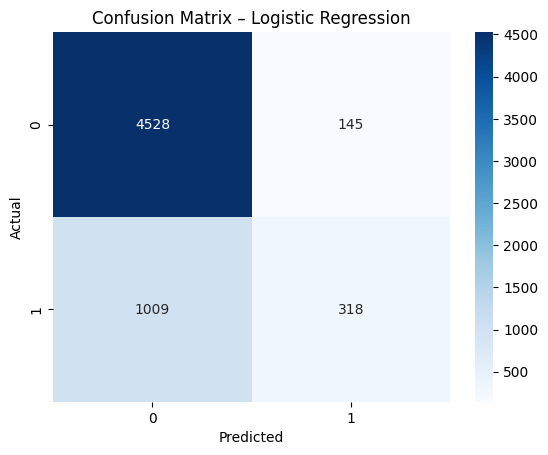

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


Classification Report:
* Precision → Of everyone flagged as default, how many actually defaulted?
* Recall → Of all the real defaulters, how many did we catch?
* F1 → Balance of precision & recall
* Accuracy → NOT helpful for imbalanced data

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000



ROC AUC:  
Evaluates how well a model distinguishes between positive and negative classes.  

AUC measures how well the model separates defaulters from non-defaulters at all thresholds.

Interpretation:
* 0.5 = random guessing
* 0.6–0.7 = weak but usable
* 0.7–0.8 = good
* 0.8+ = very strong

In [18]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.7076355036089734

Interpretation and understanding: 
1. Did the model catch most defaulters (Recall)?
2. Did the model raise many false alarms (Precision, FP count)?
3. Is the baseline reasonable?
4. What should improve next (Recall or Precision)?

**The logistic regression baseline performs reasonably, with stronger precision than recall. It correctly identifies many non-defaulters but misses some true defaulters, which is important because false negatives carry financial risk. This baseline gives a solid starting point to compare tree-based models and threshold adjustments.**